# Marvel Social Network  

This project explores the Marvel Universe as a social network.  
Characters are represented as nodes, and their co-appearances in comics form the edges.  

The analysis applies network science techniques to study connectivity,  
identify central characters, and detect community structures among heroes.  

In [122]:
import pandas as pd
import networkx as nx
from pathlib import Path
import community as community_louvain  #from python-louvain
from collections import Counter
from pyvis.network import Network
from pathlib import Path
import matplotlib.pyplot as plt


In [123]:
# resolve repo root
ROOT = Path.cwd()
if ROOT.name == "notebooks":
    ROOT = ROOT.parent

# output + docs directories
OUT_DIR  = ROOT / "outputs"
DOCS_DIR = ROOT / "docs"

OUT_DIR.mkdir(parents=True, exist_ok=True)
DOCS_DIR.mkdir(parents=True, exist_ok=True)

## Load dataset

The dataset includes two files:  
- `edges.csv` -> links heroes to the comics they appear in  
- `nodes.csv` -> lists each entity as either a hero or a comic  

Below is a preview of the first few rows to confirm structure.  

In [124]:
# Load raw CSVs
edges = pd.read_csv("../data/edges.csv")
nodes = pd.read_csv("../data/nodes.csv")

# Preview data
display(edges.head())
display(nodes.head())

,hero,comic
0,24-HOUR MAN/EMMANUEL,AA2 35
1,3-D MAN/CHARLES CHAN,AVF 4
2,3-D MAN/CHARLES CHAN,AVF 5
3,3-D MAN/CHARLES CHAN,COC 1
4,3-D MAN/CHARLES CHAN,H2 251


,node,type
0,2001 10,comic
1,2001 8,comic
2,2001 9,comic
3,24-HOUR MAN/EMMANUEL,hero
4,3-D MAN/CHARLES CHAN,hero


## Build bipartite graph -> project to hero–hero network

The dataset links heroes to the comics they appear in.  
To explore how characters are connected, I first build a bipartite graph (heroes <-> comics).  
This is then projected into a hero–hero network, where edge weights reflect the number of shared comic appearances.  

In [125]:
# Expected schema:
#  - edges: hero, comic
#  - nodes: node, type in {hero, comic}

# Check columns for sanity
print("Edges columns:", list(edges.columns))
print("Nodes columns:", list(nodes.columns))

# Build bipartite graph (heroes <-> comics)
B = nx.Graph()

heroes = set(nodes.loc[nodes["type"].str.lower() == "hero", "node"])
comics = set(nodes.loc[nodes["type"].str.lower() == "comic", "node"])

B.add_nodes_from(heroes, bipartite="hero")
B.add_nodes_from(comics, bipartite="comic")
B.add_edges_from(edges.apply(lambda r: (r["hero"], r["comic"]), axis=1))

print(f"Bipartite graph: {B.number_of_nodes():,} nodes, {B.number_of_edges():,} edges")
print(f"#heroes={len(heroes):,}, #comics={len(comics):,}")

# Projected hero–hero network (edges weighted by number of shared comics)
G = nx.algorithms.bipartite.weighted_projected_graph(B, heroes)

print(f"Hero graph: {G.number_of_nodes():,} nodes, {G.number_of_edges():,} edges")

# Sample edges with weights
list(G.edges(data=True))[:5]

Edges columns: ['hero', 'comic']
Nodes columns: ['node', 'type']
Bipartite graph: 19,091 nodes, 96,104 edges
#heroes=6,439, #comics=12,651
Hero graph: 6,440 nodes, 171,644 edges


[('CADUCEUS', 'GENII/JASON KIMBALL', {'weight': 8}),
 ('CADUCEUS', 'VALKIN', {'weight': 1}),
 ('CADUCEUS', 'HARGEN', {'weight': 1}),
 ('CADUCEUS', 'THOR/DR. DONALD BLAK', {'weight': 1}),
 ('CADUCEUS', 'JUNIPER', {'weight': 2})]

## Compute centrality metrics

On the hero–hero graph `G`, compute:
- **degree_centrality** (unweighted neighbors)
- **strength** (sum of edge weights = shared-comic counts)
- **eigenvector** (weighted)
Results are previewed (top 10 by strength) and saved to `outputs/metrics_v1.csv`.

In [126]:
# Degree centrality (unweighted)
deg = nx.degree_centrality(G)

# Strength = sum of edge weights
strength = {n: G.degree(n, weight="weight") for n in G.nodes()}

# Eigenvector centrality (weighted)
eig = nx.eigenvector_centrality(G, weight="weight", max_iter=300, tol=1e-6)

# Assemble tidy table
metrics = (
    pd.DataFrame({
        "character": list(G.nodes()),
        "degree_centrality": [deg[n] for n in G.nodes()],
        "strength": [strength[n] for n in G.nodes()],
        "eigenvector": [eig[n] for n in G.nodes()],
    })
    .sort_values("strength", ascending=False)
    .reset_index(drop=True)
)

# Preview top 10
display(metrics.head(10))

# Save to outputs/
out_csv = OUT_DIR / "metrics_v1.csv"   # OUT_DIR was set in the paths cell
metrics.to_csv(out_csv, index=False)
print(f"saved {out_csv} (rows={len(metrics):,})")

,character,degree_centrality,strength,eigenvector
0,CAPTAIN AMERICA,0.298028,16057,0.273361
1,SPIDER-MAN/PETER PARKER,0.272403,13730,0.130145
2,IRON MAN/TONY STARK,0.243205,11997,0.225258
3,THOR/DR. DONALD BLAK,0.204224,11558,0.199530
4,THING/BENJAMIN J. GR,0.224880,10772,0.231308
5,WOLVERINE/LOGAN,0.214630,10480,0.138351
6,HUMAN TORCH/JOHNNY S,0.219289,10377,0.227829
7,SCARLET WITCH/WANDA,0.211524,10168,0.215719
8,MR. FANTASTIC/REED R,0.219910,9886,0.222814
9,VISION,0.193042,9786,0.210616


saved /Users/riva/Desktop/Marvel Social Network/outputs/metrics_v1.csv (rows=6,440)


## Community detection

Detect character communities in the hero–hero network using the Louvain method.
Communities represent clusters of characters who co-appear frequently across comics.

In [127]:
# Run Louvain community detection
partition = community_louvain.best_partition(G, weight="weight")

# Attach community labels to DataFrame
metrics["community"] = metrics["character"].map(partition)

print(f"Detected {len(set(partition.values()))} communities")
display(metrics.head(10))

Detected 49 communities


,character,degree_centrality,strength,eigenvector,community
0,CAPTAIN AMERICA,0.298028,16057,0.273361,8
1,SPIDER-MAN/PETER PARKER,0.272403,13730,0.130145,6
2,IRON MAN/TONY STARK,0.243205,11997,0.225258,8
3,THOR/DR. DONALD BLAK,0.204224,11558,0.199530,0
4,THING/BENJAMIN J. GR,0.224880,10772,0.231308,14
5,WOLVERINE/LOGAN,0.214630,10480,0.138351,2
6,HUMAN TORCH/JOHNNY S,0.219289,10377,0.227829,14
7,SCARLET WITCH/WANDA,0.211524,10168,0.215719,8
8,MR. FANTASTIC/REED R,0.219910,9886,0.222814,14
9,VISION,0.193042,9786,0.210616,8


In [128]:
community_sizes = Counter(partition.values())
print("Top 5 communities by size:")
for comm, size in community_sizes.most_common(5):
    print(f"Community {comm}: {size} heroes")

Top 5 communities by size:
Community 2: 1298 heroes
Community 8: 1079 heroes
Community 6: 922 heroes
Community 15: 611 heroes
Community 14: 448 heroes


Note: Louvain community IDs (e.g., 2, 5, 6) are arbitrary labels.  
The sizes above are sorted by number of heroes, not by community ID.

## Interactive visualization (PyVis)

Build an interactive hero–hero network:
- nodes sized by **strength** (sum of shared-issue weights)
- nodes colored by **community** (Louvain)
- edges filtered to keep the file responsive

Exported to `../outputs/marvel_network.html`.

In [129]:
# viz parameters
EDGE_WT_MIN = 2      # min edge weight
TOP_N = 500          # limit to top-N nodes by strength (None = all)

# rank nodes by weighted degree (strength)
strength = {n: G.degree(n, weight="weight") for n in G.nodes()}
ranked_nodes = sorted(strength, key=strength.get, reverse=True)
keep_nodes = set(ranked_nodes[:TOP_N]) if TOP_N else set(G.nodes())

def edge_ok(u, v, data):
    return (
        u in keep_nodes and
        v in keep_nodes and
        data.get("weight", 0) >= EDGE_WT_MIN
    )

# filtered subgraph
H = G.edge_subgraph(
    [(u, v) for u, v, d in G.edges(data=True) if edge_ok(u, v, d)]
).copy()

print(
    f"Viz graph: {H.number_of_nodes():,} nodes, {H.number_of_edges():,} edges "
    f"(TOP_N={TOP_N}, EDGE_WT_MIN={EDGE_WT_MIN})"
)

# community colours
palette = [
    "#1f77b4","#ff7f0e","#2ca02c","#d62728","#9467bd",
    "#8c564b","#e377c2","#7f7f7f","#bcbd22","#17becf"
]
def comm_color(c):
    try:
        return palette[c % len(palette)]
    except Exception:
        return "#7f7f7f"

# build PyVis network
net = Network(
    height="800px", width="100%", bgcolor="#111", font_color="#eee",
    notebook=False, directed=False, cdn_resources="in_line"
)
net.barnes_hut(
    gravity=-30000, central_gravity=0.1,
    spring_length=120, spring_strength=0.01, damping=0.9
)

# lookup strength/community from metrics
metrics_lookup = metrics.set_index("character")[["strength","community"]].to_dict(orient="index")

# add nodes
for n in H.nodes():
    info = metrics_lookup.get(n, {"strength": 1.0, "community": 0})
    size = max(5, min(40, info["strength"] ** 0.5))
    color = comm_color(info["community"])
    net.add_node(
        n,
        label=n,
        title=f"{n}<br>strength={info['strength']:.0f}<br>community={info['community']}",
        color=color,
        size=size
    )

# add edges
for u, v, d in H.edges(data=True):
    w = d.get("weight", 1)
    width = 1 + min(8, w / 3)
    net.add_edge(u, v, value=w, title=f"shared issues: {w}", width=width)

# export to docs/ (for GitHub Pages)
out_html = DOCS_DIR / "marvel_network.html"
net.write_html(str(out_html), open_browser=False) 
print(f"exported {out_html}")

Viz graph: 500 nodes, 24,801 edges (TOP_N=500, EDGE_WT_MIN=2)
exported /Users/riva/Desktop/Marvel Social Network/docs/marvel_network.html


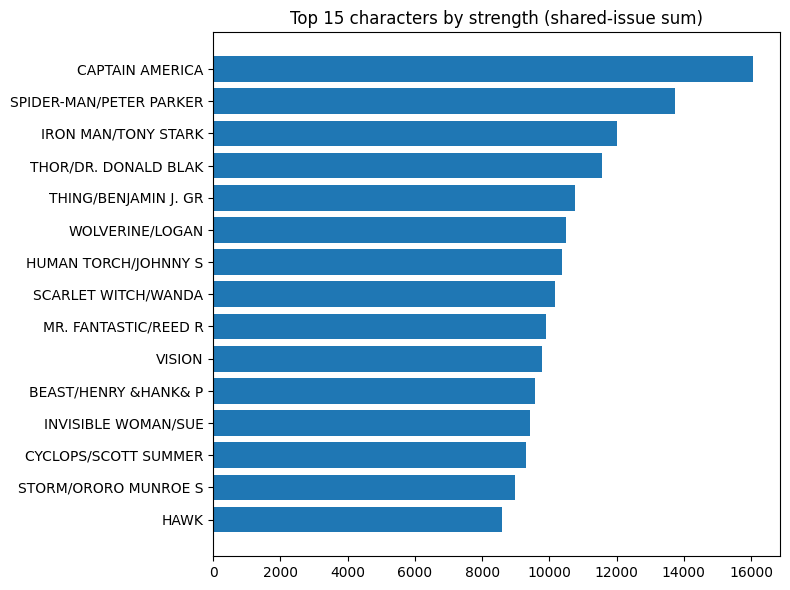

In [130]:
top15 = metrics.nlargest(15, "strength")[["character","strength"]].iloc[::-1]  # reverse for horizontal bar
plt.figure(figsize=(8, 6))
plt.barh(top15["character"], top15["strength"])
plt.title("Top 15 characters by strength (shared-issue sum)")
plt.tight_layout()
plt.show()